In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report,confusion_matrix,f1_score,roc_auc_score,ConfusionMatrixDisplay

In [113]:
path = "/Users/cyberton/Downloads/adult-all.csv"

In [114]:
df = pd.read_csv(path, header = None)

In [115]:
df.columns = ['Age','Workclass','fnlwgt','Education', 'Education-num','Marital-Status','Occupation','Relationship','Race','Sex','Capital-gain','Capital-loss','hours-per-week','native-country','Salary']

In [116]:
df

,Age,Workclass,fnlwgt,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,hours-per-week,native-country,Salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


# Cleaning up the data and outlier "?"

Dropping fnlwgt column as it is not required and doesn't make sense

In [117]:
df = df.drop(['fnlwgt'], axis=1)

In [118]:
df['Workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: Workclass, dtype: int64

In [119]:
#setting the target variable where <=50K as 0 and >50K as 1

mask = df.Salary == '>50K'
mask1 = df.Salary == '<=50K'
column_name = 'Salary'
df.loc[mask, column_name] = 1
df.loc[mask1, column_name] = 0

In [120]:
#changing the datatype of salary
df = df.astype({"Salary": int})

#Changing the question mark- If the person salary is " less than 50K " and is in school and university and not married, and his age is less than 26, We will categorize him to never worked and Occupation as not applicable

In [121]:
mask = (df.Salary == 0) & (df["Age"] < 26) & (df["Workclass"] == "?") & (df["Education"].isin(['11th', '10th', '7th-8th','9th','12th','5th-6th','1st-4th','Preschool','Bachelors','Masters','Some-college','HS-grad']))
column_name = 'Workclass'
column_name1 = 'Occupation'
df.loc[mask, column_name] = 'Never-worked'
df.loc[mask, column_name1] = 'Not-Applicable'

#Changing the question mark- If the person salary is less than 50K, and his age is more than 60(which is the average retirement age in the world, We will categorize him to Without-pay and Occupation as Not applicable.

In [122]:
mask = (df.Salary == 0) & (df["Age"] > 60) & (df["Workclass"] == "?") 
column_name = 'Workclass'
column_name1 = 'Occupation'
df.loc[mask, column_name] = 'Without-pay'
df.loc[mask, column_name1] = 'Not-Applicable'

Droping the remaining values of "?" in Workclass and Occupation as it is 2% of the whole dataset

In [124]:
df = df.drop(df[df.Workclass == '?'].index)
df = df.drop(df[df.Occupation == '?'].index)

Native-country which has values of "?" will be termed as Unknown

In [125]:
df.loc[df["native-country"] == "?", "native-country"] = "Unknown"

Will take Education as reference while labelling, will drop education_num - as It is not required

In [126]:
df = df.drop(['Education-num'],axis = 1)

In [127]:
df2=df.copy()

### Labeling the Data

Labelling education into different categories

In [128]:
def plot(column):
    if df2[column].dtype != 'int64':
        f, axes = plt.subplots(1,1,figsize=(10,5))
        sns.countplot(x=column, hue='Salary', data = df2)
        plt.xticks(rotation=90)
        plt.suptitle(column,fontsize=23)
        plt.show()
    else:
        g = sns.FacetGrid(df2, row="Salary", margin_titles=True, aspect=4, height=3)
        g.map(plt.hist,column,bins=100)
        plt.show()
    plt.show()

In [129]:
mask = df["Education"].isin(['11th', '10th', '7th-8th','9th','12th','5th-6th','1st-4th','Preschool','HS-grad'])  
column_name = 'Education'
df.loc[mask, column_name] = 'Low_Standard_Education'

In [130]:
mask = df["Education"].isin(['Prof-school','Assoc-acdm','Assoc-voc','Some-college'])  
column_name = 'Education'
df.loc[mask, column_name] = 'Medium_Standard_Education'

In [131]:
mask = df["Education"].isin(['Bachelors','Masters','Doctorate'])  
column_name = 'Education'
df.loc[mask, column_name] = 'High_Standard_Education'

Taking workclass labeling: private as 1 because the numbers are significant and more than the combined 

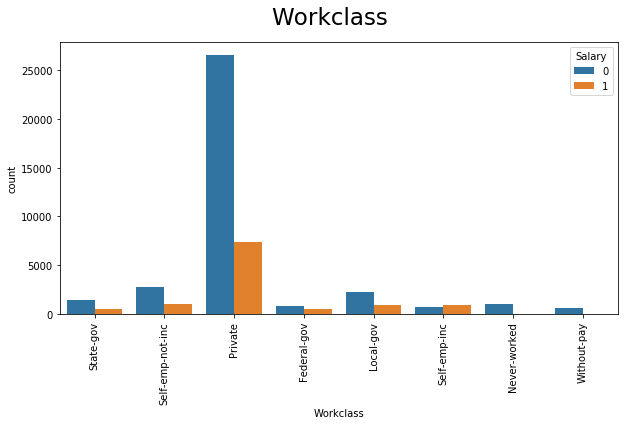

In [132]:
plot('Workclass')

In [133]:
df['Workclass']=df['Workclass'].map({'Private':1})

In [134]:
df['Workclass'].fillna(0, inplace=True)

In [183]:
df = df.astype({"Workclass": int})

### Marital Status
All married people will be 1 and others will be zero

In [136]:
mask = df["Marital-Status"].isin(['Married-civ-spouse','Married-AF-spouse'])  
column_name = 'Marital-Status'
df.loc[mask, column_name] = 1

In [137]:
mask = df["Marital-Status"].isin(['Never-married','Divorced','Separated','Widowed','Married-spouse-absent'])  
column_name = 'Marital-Status'
df.loc[mask, column_name] = 0

### Occupation

Here, I am going to seperate occupation at 3 levels - Low_standard_job, Medium_standard_job and High_standard_job

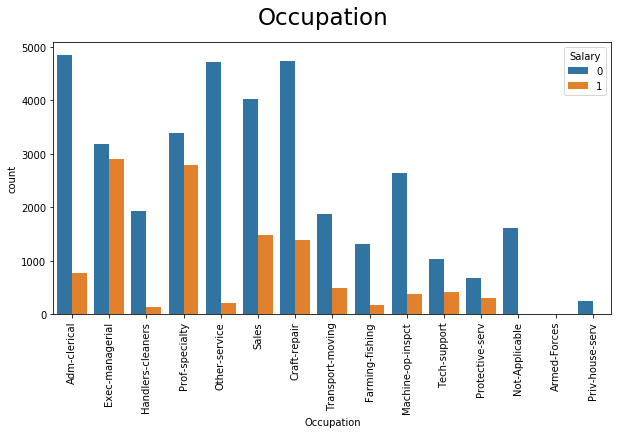

In [139]:
plot('Occupation')

In [140]:
mask = df["Occupation"].isin(['Armed-Forces','Protective-serv','Exec-managerial','Prof-specialty'])  
column_name = 'Occupation'
df.loc[mask, column_name] = "High_standard_job"

In [141]:
mask = df["Occupation"].isin(['Transport-moving','Tech-support','Adm-clerical','Sales','Machine-op-inspct'])  
column_name = 'Occupation'
df.loc[mask, column_name] = "Medium_standard_job"

In [142]:
mask = df["Occupation"].isin(['Craft-repair','Priv-house-serv','Farming-fishing','Handlers-cleaners','Other-service'])  
column_name = 'Occupation'
df.loc[mask, column_name] = "Low_standard_job"

### Relationship

I will add people who are in a family and has a specific role as 1 and others are 0

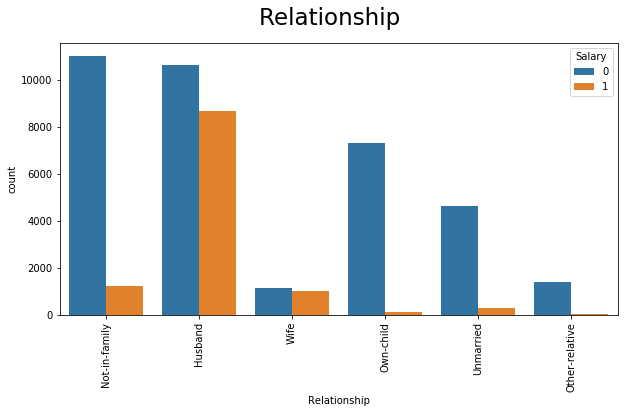

In [144]:
plot('Relationship')

In [145]:
mask = df["Relationship"].isin(['Husband','Wife','Own-child'])  
column_name = 'Relationship'
df.loc[mask, column_name] = 1

In [146]:
mask = df["Relationship"].isin(['Not-in-family','Unmarried','Other-relative'])  
column_name = 'Relationship'
df.loc[mask, column_name] = 0

### Race

As white has the highest number - we will label whites as 1 and black as 2 and Asian-Pac-Islander as 3 and Amer-Indian-Eskimo as 4 and others as 5

In [148]:
df['Race'].value_counts()

White                 40820
Black                  4504
Asian-Pac-Islander     1474
Amer-Indian-Eskimo      449
Other                   397
Name: Race, dtype: int64

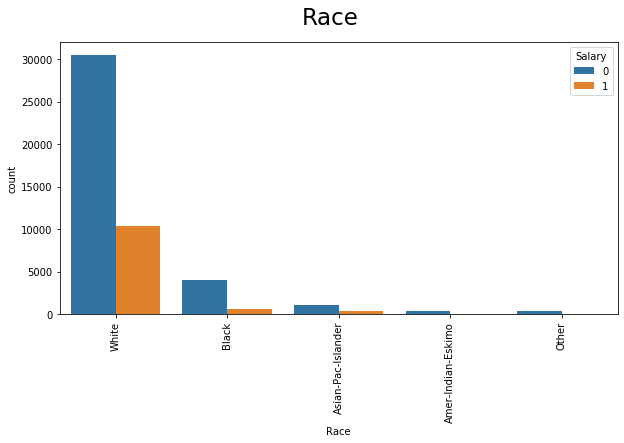

In [149]:
plot('Race')

In [150]:
#labelling and mapping race

race ={'White':1 ,'Black':2 ,'Asian-Pac-Islander':3 ,'Amer-Indian-Eskimo':4 , 'Other':5 } 

df['Race']=df['Race'].map(race)

### SEX

Changing Male to 1 and Female to 0

In [152]:
df.loc[df["Sex"] == "Female", "Sex"] = 0

In [153]:
df.loc[df["Sex"] == "Male", "Sex"] = 1

### Other column changes

No change in Capital-gain and Capital loss

### Native-Country

As the the value counts is huge in native- country column, As the count of values are more in United States

In [155]:
df.loc[df["native-country"] != "United-States", "native-country"] = 0

In [156]:
df.loc[df["native-country"] == "United-States", "native-country"] = 1

In [157]:
df

,Age,Workclass,Education,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,hours-per-week,native-country,Salary
0,39,0,High_Standard_Education,0,Medium_standard_job,0,1,1,2174,0,40,1,0
1,50,0,High_Standard_Education,1,High_standard_job,1,1,1,0,0,13,1,0
2,38,1,Low_Standard_Education,0,Low_standard_job,0,1,1,0,0,40,1,0
3,53,1,Low_Standard_Education,1,Low_standard_job,1,2,1,0,0,40,1,0
4,28,1,High_Standard_Education,1,High_standard_job,1,2,0,0,0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,1,High_Standard_Education,0,High_standard_job,0,1,0,0,0,36,1,0
48838,64,0,Low_Standard_Education,0,Not-Applicable,0,2,1,0,0,40,1,0
48839,38,1,High_Standard_Education,1,High_standard_job,1,1,1,0,0,50,1,0
48840,44,1,High_Standard_Education,0,Medium_standard_job,1,3,1,5455,0,40,1,0


In [158]:
df.dtypes

Age                int64
Workclass          int64
Education         object
Marital-Status    object
Occupation        object
Relationship      object
Race               int64
Sex               object
Capital-gain       int64
Capital-loss       int64
hours-per-week     int64
native-country    object
Salary             int64
dtype: object

## One-hot encoding 

In [159]:
 df = pd.get_dummies(df,columns =['Education','Occupation'], dtype = int, drop_first=True)

In [160]:
#changing all the rows into int

df = df.astype({"Marital-Status": int,"Relationship": int,"Sex":int,"native-country":int})

In [162]:
x=df.drop('Salary',axis=1)

In [163]:
y=df['Salary']

In [164]:
y.describe()

count    47644.000000
mean         0.239736
std          0.426927
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Salary, dtype: float64

In [165]:
#from sklearn.preprocessing import StandardScaler
#scaler=StandardScaler()

In [166]:
#x_scaled=scaler.fit_transform(x)

In [167]:
#x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=143)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=143)

In [168]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(38115, 15)
(9529, 15)
(38115,)
(9529,)


In [169]:
def evaluating_models(X_tr, X_te, y_te, r_pre, model, average, multi_class, sep=1):
    aver = average
    mult = multi_class
    confusion = confusion_matrix(y_te, r_pre)
    accuracy = accuracy_score(y_te, r_pre)
    precison = precision_score(y_te, r_pre, average=aver)
    recall = recall_score(y_te, r_pre, average=aver)
    f1 = f1_score(y_te, r_pre, average=aver)
    roc_score = roc_auc_score(y_test,r_pre)
    
    print('accuracy %:',accuracy)
    print('confusion_matrix:',confusion)
    print('presision:',precison)
    print('recall:',recall)
    print('f1 score : ',f1)
    print('roc_auc_score :',roc_score)

    cm = confusion_matrix(y_te, r_pre, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

In [173]:
def K_Nearest_Neighbours(x_train, x_tst, y_train, y_tst,nghbr):
    
    knn=KNeighborsClassifier(n_neighbors= nghbr)
    model=knn.fit(x_train,y_train)
    pred = model.predict(x_tst)

    evaluating_models(x_train, x_tst, y_tst, pred, model=knn, average='macro', multi_class='ovr', sep=0)
    
    results = []
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(knn, x_train, y_train, cv=kfold, scoring='accuracy')
    print("CrossValidation Accuracy score: ", cv_results.mean())

### For K-value = 12

accuracy %: 0.852555357330255
confusion_matrix: [[6795  421]
 [ 984 1329]]
presision: 0.8164670817034874
recall: 0.7581179487290097
f1 score :  0.7802492536481722
roc_auc_score : 0.7581179487290097
CrossValidation Accuracy score:  0.8524465433556344


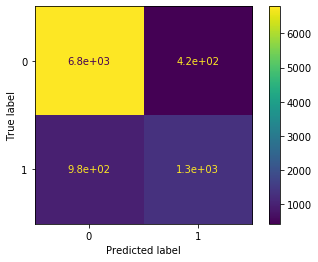

In [180]:
K_Nearest_Neighbours(x_train, x_test, y_train, y_test,12)

### For K-value = 13

accuracy %: 0.8522405289117431
confusion_matrix: [[6704  512]
 [ 896 1417]]
presision: 0.8083413822269515
recall: 0.7708354303210525
f1 score :  0.7865243482077304
roc_auc_score : 0.7708354303210525
CrossValidation Accuracy score:  0.851843106388561


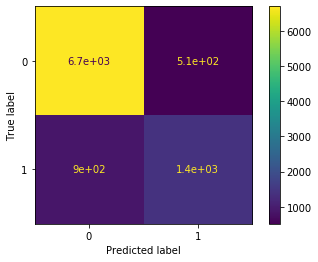

In [181]:
K_Nearest_Neighbours(x_train, x_test, y_train, y_test,13)

### For K value = 17

accuracy %: 0.8497219015636478
confusion_matrix: [[6723  493]
 [ 939 1374]]
presision: 0.8066935762254112
recall: 0.7628566616626549
f1 score :  0.7805833860212985
roc_auc_score : 0.7628566616626549
CrossValidation Accuracy score:  0.8518955791683064


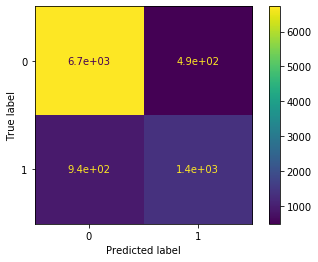

In [182]:
K_Nearest_Neighbours(x_train, x_test, y_train, y_test,17)